# Tagging Analysis - Performance Analysis

In [139]:
%matplotlib inline
import pandas as pd
from pymongo import MongoClient
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display, HTML
from scipy import stats
from bson.objectid import ObjectId
import random
import json
client = MongoClient('localhost')
db = client['crowdy']
from Crypto.Cipher import AES
import base64

secret_key = "".join([str(random.randint(0,9)) for i in range(0,16)])
cipher = AES.new(secret_key,AES.MODE_ECB)
def encrypt(s):
    s = s+"#"*(16 - len(s) % 16) # Pad string to 16 char multiple
    return base64.b64encode(cipher.encrypt(s))

In [6]:
print db.collection_names()
hits = db.hits
ts = db.tasksets

[u'bonus', u'hits', u'pins', u'system.indexes', u'tagqualities', u'tasksets', u'trainingsets', u'turkbackups']


### Retrieve results

In [156]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
search = ts.aggregate([
    {"$match":{"meta.type":"image tagging", "meta.test":False}},
    {"$unwind":"$tasks"}, {"$unwind":"$tasks.contribution.tags"},
    {"$project":{"tag":{"$toLower":"$tasks.contribution.tags"},
                 "item":"$tasks.item.id",
                'condition':'$meta.condition',
                 'user':1}}
])
all_tags = pd.DataFrame(list(search)).drop('_id',axis=1)

all_tags['user'] = all_tags['user'].apply(encrypt)
all_tags['item'] = all_tags['item'].apply(lambda x: "%.0f" % x)
print all_tags.shape
all_tags.iloc[:5]

(5116, 4)


,condition,item,tag,user
0,fast,46161964904498648,grammy awards fashion,RaVR5cqEXHzBdI36fhw6Dg==
1,fast,46161964904498648,kesha grammy outfit,RaVR5cqEXHzBdI36fhw6Dg==
2,fast,46232333648991680,what shoes to wear on a night out,RaVR5cqEXHzBdI36fhw6Dg==
3,fast,46232333648991680,yellow high heel shoe,RaVR5cqEXHzBdI36fhw6Dg==
4,fast,109001253451458832,natural hair style,RaVR5cqEXHzBdI36fhw6Dg==


### Retrieval manual tag judgments

In [157]:
search = db.tagqualities.find()
all_answers = pd.DataFrame(list(search)).rename(columns={'item_id':'item'}).drop(['_id','__v'], axis=1)
all_answers['item'] = all_answers['item'].apply(lambda x: "%.0f" % x)
all_answers['judgment'] = all_answers['quality'].apply(lambda x: int(x))
all_answers['quality'] = all_answers['judgment'].apply(lambda x: ['toohard','poor','ok','good','great'][x])
print all_answers.shape
all_answers.iloc[:5]

(1976, 4)


,item,quality,tag,judgment
0,10414642858052268,great,wooden,4
1,10414642858052268,ok,wood floors,2
2,10414642858052268,ok,wood,2
3,10414642858052268,ok,natural decor,2
4,10414642858052268,good,living room,3


In [87]:
judged = pd.merge(all_tags, all_answers, how='left')
judged.iloc[:5]

,condition,item,tag,user,quality,judgment
0,fast,46161964904498648,grammy awards fashion,KywcGqF/PSVF/sWjyVd7Fg==,good,3.000
1,fast,46161964904498648,kesha grammy outfit,KywcGqF/PSVF/sWjyVd7Fg==,great,4.000
2,fast,46232333648991680,what shoes to wear on a night out,KywcGqF/PSVF/sWjyVd7Fg==,ok,2.000
3,fast,46232333648991680,yellow high heel shoe,KywcGqF/PSVF/sWjyVd7Fg==,great,4.000
4,fast,109001253451458832,natural hair style,KywcGqF/PSVF/sWjyVd7Fg==,ok,2.000


### Overall stats

In [88]:
a = judged.groupby(['condition']).mean().reset_index()
judged.groupby('condition').agg([np.mean, 
            np.median, 
            np.std,
            len
           ])

judgment                      
                 mean median   std      len
condition                                  
basic           2.714  3.000 1.003 2103.000
fast            2.447  2.000 0.979 1155.000
feedback        2.638  3.000 0.909  576.000
postTraining    3.066  3.000 0.900 1141.000

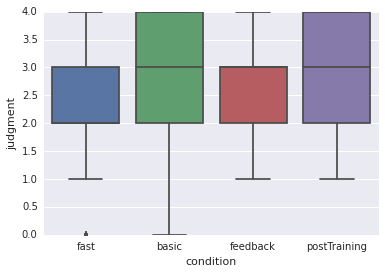

In [62]:
ax = sns.boxplot(x="condition", y="judgment", data=judged)

(array([ 0.5,  1.5,  2.5,  3.5]), <a list of 4 Text yticklabel objects>)

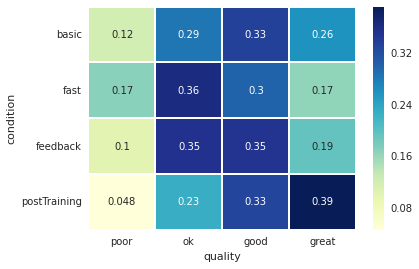

In [141]:
a = judged.groupby(['condition', 'quality']).count().reset_index()\
    .rename(columns={'item':'count'}).drop(['tag', 'user','judgment'],axis=1)\
    .pivot('condition', 'quality')
a.columns = a.columns.droplevel()
a = a.drop('toohard', axis=1)
a = a.div(a.sum(axis=1), axis=0)
#uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(a[['poor', 'ok', 'good', 'great']], 
                 annot=True, linewidths=.5, cmap="YlGnBu")
plt.yticks(rotation=0) 

Since this is ordinal data with a categorical input, the Kruskall-Wallis Test will allow us to compare distributions against the baseline.

In [155]:
conditions =  judged['condition'].unique()
conditions

x = 'basic'
xtimes = judged[judged['condition'] == x]['judgment']
for y in conditions:
    if x == y:
        continue
    ytimes = judged[judged['condition'] == y]['judgment']
    print x, y, stats.mstats.kruskal(xtimes,ytimes)

stats.mstats.kruskal(judged.query('condition=="basic"')['judgment'],
                     judged.query('condition=="feedback"')['judgment'],
                    judged.query('condition=="fast"')['judgment'],
                    judged.query('condition=="postTraining"')['judgment'])

basic fast KruskalResult(statistic=53.252292032045283, pvalue=2.9334499515009992e-13)
basic feedback KruskalResult(statistic=2.8129568127169144, pvalue=0.093505886553418613)
basic postTraining KruskalResult(statistic=37.974843306767362, pvalue=7.1662716065827199e-10)


KruskalResult(statistic=123.89366092788933, pvalue=1.1188242176980703e-26)

### Stats relative to user

In [132]:
a = judged.groupby(['condition', 'user']).mean().reset_index()
a.groupby('condition').agg([np.mean, 
            np.median, 
            np.std,
            len
           ])

judgment                    
                 mean median   std    len
condition                                
basic           2.631  2.550 0.353 51.000
fast            2.526  2.477 0.352 16.000
feedback        2.746  2.702 0.215  8.000
postTraining    3.056  3.062 0.250 15.000

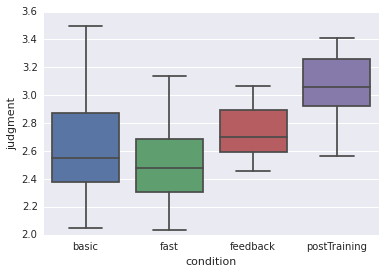

In [64]:
ax = sns.boxplot(x="condition", y="judgment", data=a)

In [59]:
def percentByGroup(x):
    defaults = pd.Series({"Not Relevant":0, "Somewhat Relevant":0, "Very Relevant":0})
    p = x.groupby('judgment').count()['item'].div(len(x))
    return p.add(defaults, fill_value=0)

judgment_likelihood = all_ratings.groupby(["query","item"]).apply(percentByGroup)

judgment_likelihood

Not Relevant  Somewhat Relevant  \
query             item                                                  
agape             103512491405117920         0.929              0.071   
                  132293307774792368         0.500              0.429   
                  146226319122668288         1.000              0.000   
                  162762974005815584         0.724              0.207   
                  185351340889599296         0.655              0.207   
                  208502657719932928         0.893              0.107   
                  21744010675101592          1.000              0.000   
                  223068987764744032         1.000              0.000   
                  231935449529472800         0.806              0.032   
                  239042692691878784         0.929              0.071   
                  240520436319330240         0.929              0.000   
                  284008320221103040         1.000              0.000   
                  332914597426856704         1.000              0.000   
                  340162578077931328         1.000              0.000   
                  359865826446771328         0.571              0.214   
                  367395282074502080         0.968              0.032   
                  40321359138635528          0.964              0.036   
                  407153622532869824         0.893              0.071   
                  413416440767365696         0.862              0.034   
                  416301559277225280         0.931              0.000   
                  454159943645113344         1.000              0.000   
                  467248530061936128         0.481              0.333   
                  469500329873456832         0.903              0.065   
                  494973815268162752         0.929              0.071   
                  496662665129752192         0.800              0.133   
                  501799583453071744         0.897              0.034   
                  518054763356656320         0.926              0.000   
                  53550683039109584          0.690              0.276   
                  61291244899996240          0.964              0.000   
                  86272149083353136          0.903              0.065   
...                                            ...                ...   
window treatments 108227197265708368         0.893              0.107   
                  1196337376007752           0.036              0.036   
                  145100419217831776         0.074              0.111   
                  174021973076484832         0.714              0.214   
                  187110559491879296         1.000              0.000   
                  227009637441247104         0.032              0.065   
                  237846424040395136         0.000              0.071   
                  246783254550840608         0.000              0.000   
                  280630620504931168         0.000              0.000   
                  288230444875397248         0.000              0.000   
                  29203097553431556          0.000              0.000   
                  294985844312776448         0.964              0.036   
                  301952349989595008         0.710              0.226   
                  304907837243541248         0.286              0.464   
                  344032859004226368         0.071              0.679   
                  377035800027386432         1.000              0.000   
                  39336196720381240          0.655              0.172   
                  473018767082728448         0.000              0.000   
                  493073859174076160         0.931              0.069   
                  49961877088272152          0.000              0.037   
                  508484614148206848         1.000              0.000   
                  530228556099753728         1.000              0.000   
                  56083

In [134]:
# Melt from wide to long format
judgescores = pd.melt(
    judgment_likelihood.reset_index(),
    id_vars=["query", "item"],
    value_vars=["Not Relevant", "Somewhat Relevant","Very Relevant"],
    value_name="probability"
)
judgescores.iloc[1000:1005]

,query,item,variable,probability
1000,no bake cookies,275915914646186464,Very Relevant,0.407
1001,no bake cookies,28991991323446248,Very Relevant,0.000
1002,no bake cookies,30047522487693852,Very Relevant,0.000
1003,no bake cookies,305259680966452928,Very Relevant,0.960
1004,no bake cookies,305330049710469696,Very Relevant,0.103


This short function chooses the most likely vote.

In [135]:
def topvote(x):
    x = x.sort('probability', ascending=False)
    return x.iloc[0]

judgescores.groupby(["query","item"]).apply(topvote).iloc[200:205]

query                item  \
query             item                                                        
jennifer lawrence 482448178804881920  jennifer lawrence  482448178804881920   
                  511932682615993728  jennifer lawrence  511932682615993728   
                  535998793124446272  jennifer lawrence  535998793124446272   
                  535998793124744704  jennifer lawrence  535998793124744704   
                  535998793124836992  jennifer lawrence  535998793124836992   

                                           variable  probability  
query             item                                            
jennifer lawrence 482448178804881920  Very Relevant        1.000  
                  511932682615993728  Very Relevant        1.000  
                  535998793124446272  Very Relevant        0.963  
                  535998793124744704  Very Relevant        0.552  
                  535998793124836992  Very Relevant        0.963

Now let's compare performance

In [291]:
search = ts.aggregate([
    {"$match":{"meta.type":"relevance judgments", "meta.test":False}},
    {"$unwind":"$tasks"},
    {"$project":{"judgment":"$tasks.contribution.relevance", 
                 "query":"$facet.meta.query", "item":"$tasks.item.id", "user":1,
                'condition':'$meta.condition', 'timeOfDay':{'$hour':'$time.start'}}},
    {"$unwind":"$judgment"}
])
ratings = pd.DataFrame(list(search)).drop('_id', axis=1)
ratings['item'] = ratings['item'].apply(lambda x: "%.0f" % x)

# Encrypt the user column, in case this repo every goes public
secret_key = "".join([str(random.randint(0,9)) for i in range(0,16)])
cipher = AES.new(secret_key,AES.MODE_ECB)
def encrypt(s):
    s = s+"#"*(16 - len(s) % 16) # Pad string to 16 char multiple
    return base64.b64encode(cipher.encrypt(s))
ratings['user'] = ratings['user'].apply(encrypt)
ratings.iloc[:5]

,condition,item,judgment,query,timeOfDay,user
0,basic,95138610847720400,Not Relevant,buffalo chicken dip,19,r2dDIb6mZvsV1Jb1QIa+PQ==
1,basic,160651911678677888,Not Relevant,buffalo chicken dip,19,r2dDIb6mZvsV1Jb1QIa+PQ==
2,postTraining,160229699215772032,Very Relevant,rose tattoo,22,SCKXJVmxI43DB4oJJCgOfA==
3,feedback,1829656070146753,Very Relevant,thanksgiving decorations,21,gHU6+U3lj9rbfJ8/NvhuPA==
4,feedback,292030357057520064,Not Relevant,feather tattoo,21,CNlsbMj3cx4oHF9nXxtp+Q==


In [295]:
ratings.groupby(['condition','timeOfDay']).count()

item  judgment  query  user
condition    timeOfDay                             
basic        1           180       180    180   180
             2            50        50     50    50
             3           137       137    137   137
             4             7         7      7     7
             18         1189      1189   1189  1189
             19           95        95     95    95
             20           53        53     53    53
             21          183       183    183   183
fast         18          245       245    245   245
             19         1097      1097   1097  1097
             20          575       575    575   575
             21            4         4      4     4
feedback     1           788       788    788   788
             2           919       919    919   919
             3          1003      1003   1003  1003
             21          608       608    608   608
postTraining 0            25        25     25    25
             22         1337      1337   1337  1337
             23          444       444    444   444
training     23         2360      2360   2360  2360

This DataFrame, `allscores`, lists the probability of each possibile judgment being correct, and allso assigns a binary vote to identify whether it is the *best* choice.

In [231]:
probs = judgescores.rename(columns={'variable':'judgment'}).sort(['query', 'item'])
votes = judgescores.rename(columns={'variable':'judgment'}) \
    .groupby(["query","item"]).apply(topvote).reset_index(drop=True) \
    .drop('probability', axis=1)
votes['vote'] = 1
allscores = pd.merge(probs, votes, how='outer').fillna(0)
allscores.iloc[600:610]

,query,item,judgment,probability,vote
600,jennifer lawrence,482448178804881920,Not Relevant,0.000,0.000
601,jennifer lawrence,482448178804881920,Somewhat Relevant,0.000,0.000
602,jennifer lawrence,482448178804881920,Very Relevant,1.000,1.000
603,jennifer lawrence,511932682615993728,Not Relevant,0.000,0.000
604,jennifer lawrence,511932682615993728,Somewhat Relevant,0.000,0.000
605,jennifer lawrence,511932682615993728,Very Relevant,1.000,1.000
606,jennifer lawrence,535998793124446272,Not Relevant,0.000,0.000
607,jennifer lawrence,535998793124446272,Somewhat Relevant,0.037,0.000
608,jennifer lawrence,535998793124446272,Very Relevant,0.963,1.000
609,jennifer lawrence,535998793124744704,Not Relevant,0.138,0.000


Now we should merge `allscores` with the worker's actual judgments.

In [248]:
judged = pd.merge(ratings, allscores, how='left')
judged.iloc[:5]

,condition,item,judgment,query,user,probability,vote
0,basic,95138610847720400,Not Relevant,buffalo chicken dip,L42+QS3E9oxAGtOrNPWTtQ==,0.655,1.000
1,basic,160651911678677888,Not Relevant,buffalo chicken dip,L42+QS3E9oxAGtOrNPWTtQ==,0.704,1.000
2,postTraining,160229699215772032,Very Relevant,rose tattoo,dmZuEIZOWdpGF8WYBhqq1g==,1.000,1.000
3,feedback,1829656070146753,Very Relevant,thanksgiving decorations,6XaDElWoahG6O/UcZmbkDw==,0.321,0.000
4,feedback,292030357057520064,Not Relevant,feather tattoo,SfvatdPHZCah4FPZORhIVA==,0.926,1.000


In [273]:
a = judged.groupby(['condition', 'user']).mean().reset_index()
a.groupby('condition').agg([np.mean, 
            np.median, 
            np.std,
            len
           ])

probability                      vote                    
                    mean median   std    len  mean median   std    len
condition                                                             
basic              0.671  0.657 0.133 80.000 0.750  0.758 0.174 80.000
fast               0.632  0.650 0.145 34.000 0.685  0.721 0.195 34.000
feedback           0.684  0.681 0.098 32.000 0.770  0.795 0.117 32.000
postTraining       0.571  0.581 0.120 34.000 0.657  0.700 0.174 34.000
training           0.671  0.689 0.089 20.000 0.762  0.787 0.112 20.000

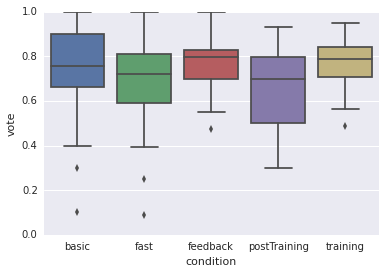

In [321]:
ax = sns.boxplot(x="condition", y="vote", data=a)

A couple questions

- How about direct comparisons of the same people (esp for feedback)
- What about a comparison of people during the course of a feedback interaction?
- What about people relative to the feedback that they recieved?
    - Or if we don't have rank saved, what about simply the performance as we increase in the number of hits?
- What about alternate (per query) training intervention?
- What about outliers? 
- *What about postTraining relative to just the compared queries???*
- How to measure significance? Mitra uses Cramer's V

In [326]:
base = a.query('condition == "basic"')['vote']
feed = a.query('condition == "feedback"')['vote']
print  stats.ttest_ind(base, feed)
print  stats.mannwhitneyu(base, feed)

conditions =  a['condition'].unique()
conditions
for x in conditions:
    xtimes = a[a['condition'] == x]['vote']
    for y in conditions:
        if x == y:
            break
        ytimes = a[a['condition'] == y]['vote']
        print x, y, stats.ttest_ind(xtimes,ytimes)
        print x, y, stats.mannwhitneyu(xtimes,ytimes)

Ttest_indResult(statistic=-0.58018876457380764, pvalue=0.5629739281763475)
MannwhitneyuResult(statistic=1237.0, pvalue=0.39166034143304396)
fast basic Ttest_indResult(statistic=-1.7773073426741617, pvalue=0.078232058191359005)
fast basic MannwhitneyuResult(statistic=1115.5, pvalue=0.064867701571321087)
feedback basic Ttest_indResult(statistic=0.58018876457380764, pvalue=0.5629739281763475)
feedback basic MannwhitneyuResult(statistic=1237.0, pvalue=0.39166034143304396)
feedback fast Ttest_indResult(statistic=2.1300311533127285, pvalue=0.037019431180974047)
feedback fast MannwhitneyuResult(statistic=396.0, pvalue=0.029175551561314871)
postTraining basic Ttest_indResult(statistic=-2.6384337286929527, pvalue=0.0095143885749078439)
postTraining basic MannwhitneyuResult(statistic=948.0, pvalue=0.0052423907881335536)
postTraining fast Ttest_indResult(statistic=-0.63139911833565088, pvalue=0.52996037691602293)
postTraining fast MannwhitneyuResult(statistic=526.0, pvalue=0.26361193755963147)
po

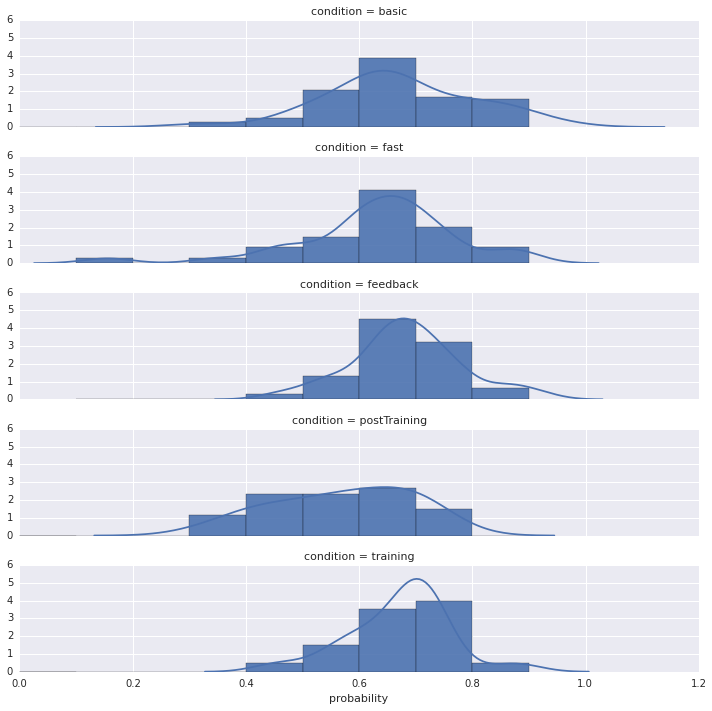

In [300]:
g = sns.FacetGrid(a, row='condition', size=2, aspect=5, margin_titles=False)
g.map(sns.distplot, "probability", 
      kde=True, rug=False, 
      hist_kws={'alpha':0.9},
      bins=np.arange(0, 1, 0.1))

While we have this information, which queries were most uncertain, and which ones were most relevant, and which ones were least relevant?

**Most uncertain queries:**

In [70]:
judgescores.groupby(["query","item"]).max().reset_index().groupby("query").mean().sort('probability')

,probability
query,
thanksgiving decorations,0.626
upcycle,0.658
no bake cookies,0.669
puppies,0.690
buffalo chicken dip,0.698
christmas ideas,0.763
islam,0.765
easter crafts,0.776
rose tattoo,0.777


**Most relevant and non-relevant**:

In [253]:
a = judgescores.groupby(["query","item"]).apply(topvote)
b = a.groupby(["query", "variable"]).count()
print "Most non-relevant"
print b.query('variable == "Not Relevant"').sort("item", ascending=False).iloc[:5]

print "Most relevant"
print b.query('variable == "Very Relevant"').sort("item", ascending=False).iloc[:5]

Most non-relevant
                                       item  probability
query                    variable                       
agape                    Not Relevant    30           30
buffalo chicken dip      Not Relevant    25           25
feather tattoo           Not Relevant    24           24
rose tattoo              Not Relevant    16           16
thanksgiving decorations Not Relevant    13           13
Most relevant
                                 item  probability
query             variable                        
christmas ideas   Very Relevant    27           27
jennifer lawrence Very Relevant    27           27
easter crafts     Very Relevant    24           24
upcycle           Very Relevant    22           22
islam             Very Relevant    20           20
